In [ ]:
### dependencies

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
# nltk.download('stopwords')
warnings.filterwarnings("ignore", category=DeprecationWarning) 
%matplotlib inline
sns.set()

In [2]:
### import dataset

In [3]:
targetset = pd.read_csv('output/hotel_review_data.csv')
len(targetset)

9787

In [4]:
###There are cities named the same in multiple states. Need to combine to make unique.

In [5]:
targetset["city_and_state"] = targetset["city"] + ", " + targetset["province"]

In [6]:
### checking how many reviews are associated with which cities. Machine learning will not work if there isn't enough data.

In [7]:
targetset["city_and_state"].value_counts()

San Diego, CA        1188
San Francisco, CA     808
New Orleans, LA       797
Atlanta, GA           761
Orlando, FL           723
                     ... 
Springfield, VA         1
New Braunfels, TX       1
Delmont, PA             1
Sneads Ferry, NC        1
Montello, WI            1
Name: city_and_state, Length: 893, dtype: int64

In [8]:
### curating out low review counts

In [9]:
cutoff = targetset.groupby("city_and_state").filter(lambda x:len(x)>10)
len(cutoff)
cutoff["city"].value_counts()

San Diego          1188
San Francisco       808
New Orleans         797
Atlanta             761
Orlando             723
                   ... 
Santa Monica         11
Gatlinburg           11
Tulsa                11
King of Prussia      11
Kearney              11
Name: city, Length: 64, dtype: int64

In [10]:
cutoff.head()

,id,address,city,country,latitude,longitude,name,postalCode,province,reviews_rating,reviews_text,reviews_title,sourceURLs,city_and_state
5,AVweLARAByjofQCxv5vX,167 W Main St,Lexington,US,38.047014,-84.497742,21c Museum Hotel Lexington,40507,KY,4,"This is such a fun, lovely hotel. The attentio...",Loved staying here,https://www.tripadvisor.com/Hotel_Review-g3958...,"Lexington, KY"
6,AVweLARAByjofQCxv5vX,167 W Main St,Lexington,US,38.047014,-84.497742,21c Museum Hotel Lexington,40507,KY,1,We recently stayed at this hotel on a trip to ...,Does not live up to its reputation,https://www.tripadvisor.com/Hotel_Review-g3958...,"Lexington, KY"
8,AVz6h4Sb3D1zeR_xDHsu,2240 Buena Vista Rd,Lexington,US,38.042100,-84.427100,Microtel Inn Suites By Wyndham Lexington,40505,KY,5,MoreMore,Location Location Location,https://www.yellowbook.com/profile/microtel-in...,"Lexington, KY"
10,AVwcuo0eIN2L1WUfoPEk,1953 Nicholasville Rd,Lexington,US,38.012430,-84.516350,Hampton Inn Lexington Medical Center,40503,KY,5,This is a new Hampton Inn and is well decorate...,Beautiful hotel,https://www.yellowpages.com/lexington-ky/mip/h...,"Lexington, KY"
13,AWV8VsCtRxPSIh2RyTvS,610 Poydras St,New Orleans,US,29.949125,-90.069748,The Whitney Hotel,70130,LA,3,The water is very hot and there's no cold wate...,"Very hot water, bad food",https://www.tripadvisor.com/Hotel_Review-g6086...,"New Orleans, LA"


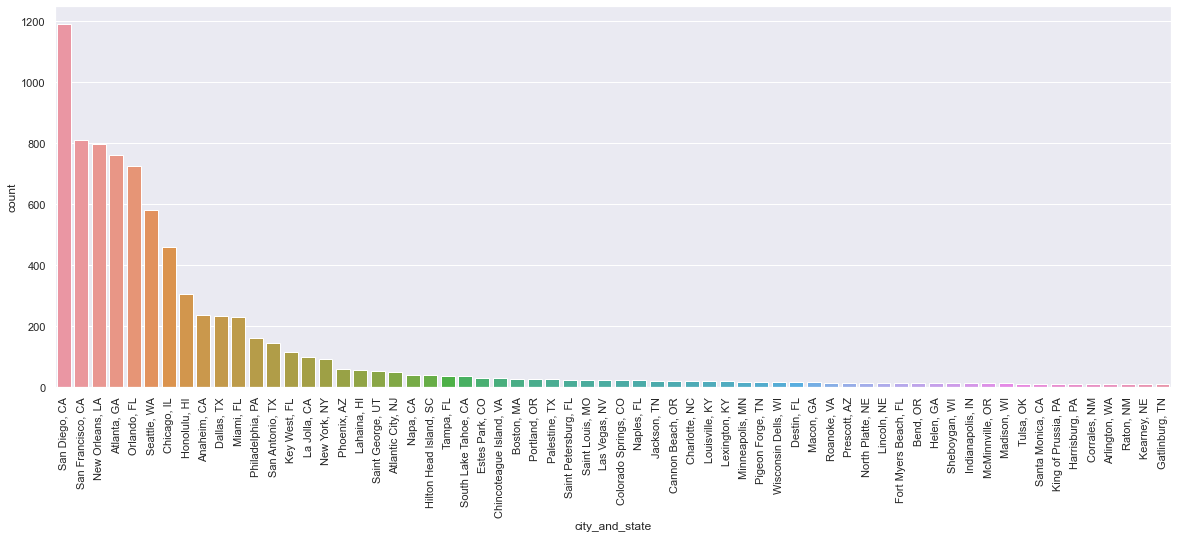

In [11]:
xaxis = cutoff.city_and_state.value_counts().index.tolist()
fig1 = plt.subplots(figsize = (20,7))
sns.countplot(x='city_and_state', data=cutoff, order = xaxis)
plt.xticks(rotation = 90)
plt.show()

In [12]:
### NLP PROCESSING

In [22]:
from utils import preprocess_text
cutoff["reviews_text_tokens"] = cutoff["reviews_text"].apply(lambda x: preprocess_text(x, min_word_length=4))
cutoff.head()

,id,address,city,country,latitude,longitude,name,postalCode,province,reviews_rating,reviews_text,reviews_title,sourceURLs,city_and_state,reviews_text_tokens
5,AVweLARAByjofQCxv5vX,167 W Main St,Lexington,US,38.047014,-84.497742,21c Museum Hotel Lexington,40507,KY,4,"This is such a fun, lovely hotel. The attentio...",Loved staying here,https://www.tripadvisor.com/Hotel_Review-g3958...,"Lexington, KY","[lovely, hotel, attention, detail, impressive,..."
6,AVweLARAByjofQCxv5vX,167 W Main St,Lexington,US,38.047014,-84.497742,21c Museum Hotel Lexington,40507,KY,1,We recently stayed at this hotel on a trip to ...,Does not live up to its reputation,https://www.tripadvisor.com/Hotel_Review-g3958...,"Lexington, KY","[recently, stay, hotel, trip, lexington, frien..."
8,AVz6h4Sb3D1zeR_xDHsu,2240 Buena Vista Rd,Lexington,US,38.042100,-84.427100,Microtel Inn Suites By Wyndham Lexington,40505,KY,5,MoreMore,Location Location Location,https://www.yellowbook.com/profile/microtel-in...,"Lexington, KY",[moremore]
10,AVwcuo0eIN2L1WUfoPEk,1953 Nicholasville Rd,Lexington,US,38.012430,-84.516350,Hampton Inn Lexington Medical Center,40503,KY,5,This is a new Hampton Inn and is well decorate...,Beautiful hotel,https://www.yellowpages.com/lexington-ky/mip/h...,"Lexington, KY","[hampton, decorate, color, scheme, give, feel,..."
13,AWV8VsCtRxPSIh2RyTvS,610 Poydras St,New Orleans,US,29.949125,-90.069748,The Whitney Hotel,70130,LA,3,The water is very hot and there's no cold wate...,"Very hot water, bad food",https://www.tripadvisor.com/Hotel_Review-g6086...,"New Orleans, LA","[water, cold, water, awful, food, good, staff,..."


In [30]:
import string
string.punctuation
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
#punc = ['.', ',', '"', '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
# punc = string.punctuation
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

desc = cutoff["reviews_text"].values
desc2 = cutoff["reviews_text_tokens"].values
vectorizer = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 2000)
X = vectorizer.fit_transform(desc)
word_features = vectorizer.get_feature_names()
word_features[:50]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


AttributeError: 'list' object has no attribute 'lower'

In [ ]:
word_features = vectorizer.get_feature_names()
len(word_features)

In [ ]:
print(word_features)

In [40]:
kmeans = KMeans(n_clusters = 64)
kmeans.fit(X)

KMeans(n_clusters=64)

In [41]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(word_features[word] for word in centroid))

0 : park, hotel, fee, stay, veri, room, car, night, onli, clean
1 : park, room, hotel, car, locat, veri, block, walk, clean, floor
2 : mattress, room, bed, veri, dirti, clean, hotel, night, like, onli
3 : miami, mandarin, orient, hotel, servic, beach, veri, brickel, stay, staff
4 : dalla, hawthorn, regard, stay, suit, central, time, staff, veri, guest
5 : guest, orlando, hilton, airport, garden, ,alex, blancogener, perform, sincer, outstand
6 : seattl, hyatt, needl, hous, jung, space, guest, !sarah, stay, .sarah
7 : western, baysid, harbor, best, plus, inn, diego, stay, cabrillo, san
8 : seattl, hotel, stay, hyatt, walk, grand, room, great, downtown, veri
9 : guest, stay, feedback, experi, hotel, improv, apolog, room, hope, thank
10 : smoke, room, smell, hotel, non, -smoke, stay, becaus, veri, great
11 : key, west, orchid, ...more, duval, inn, stay, veri, staff, room
12 : western, best, diego, san, /miramar., thank, miramar, stay, plus, provid
13 : amaz, hotel, great, room, love, staff

In [42]:
cutoff['cluster'] = kmeans.labels_

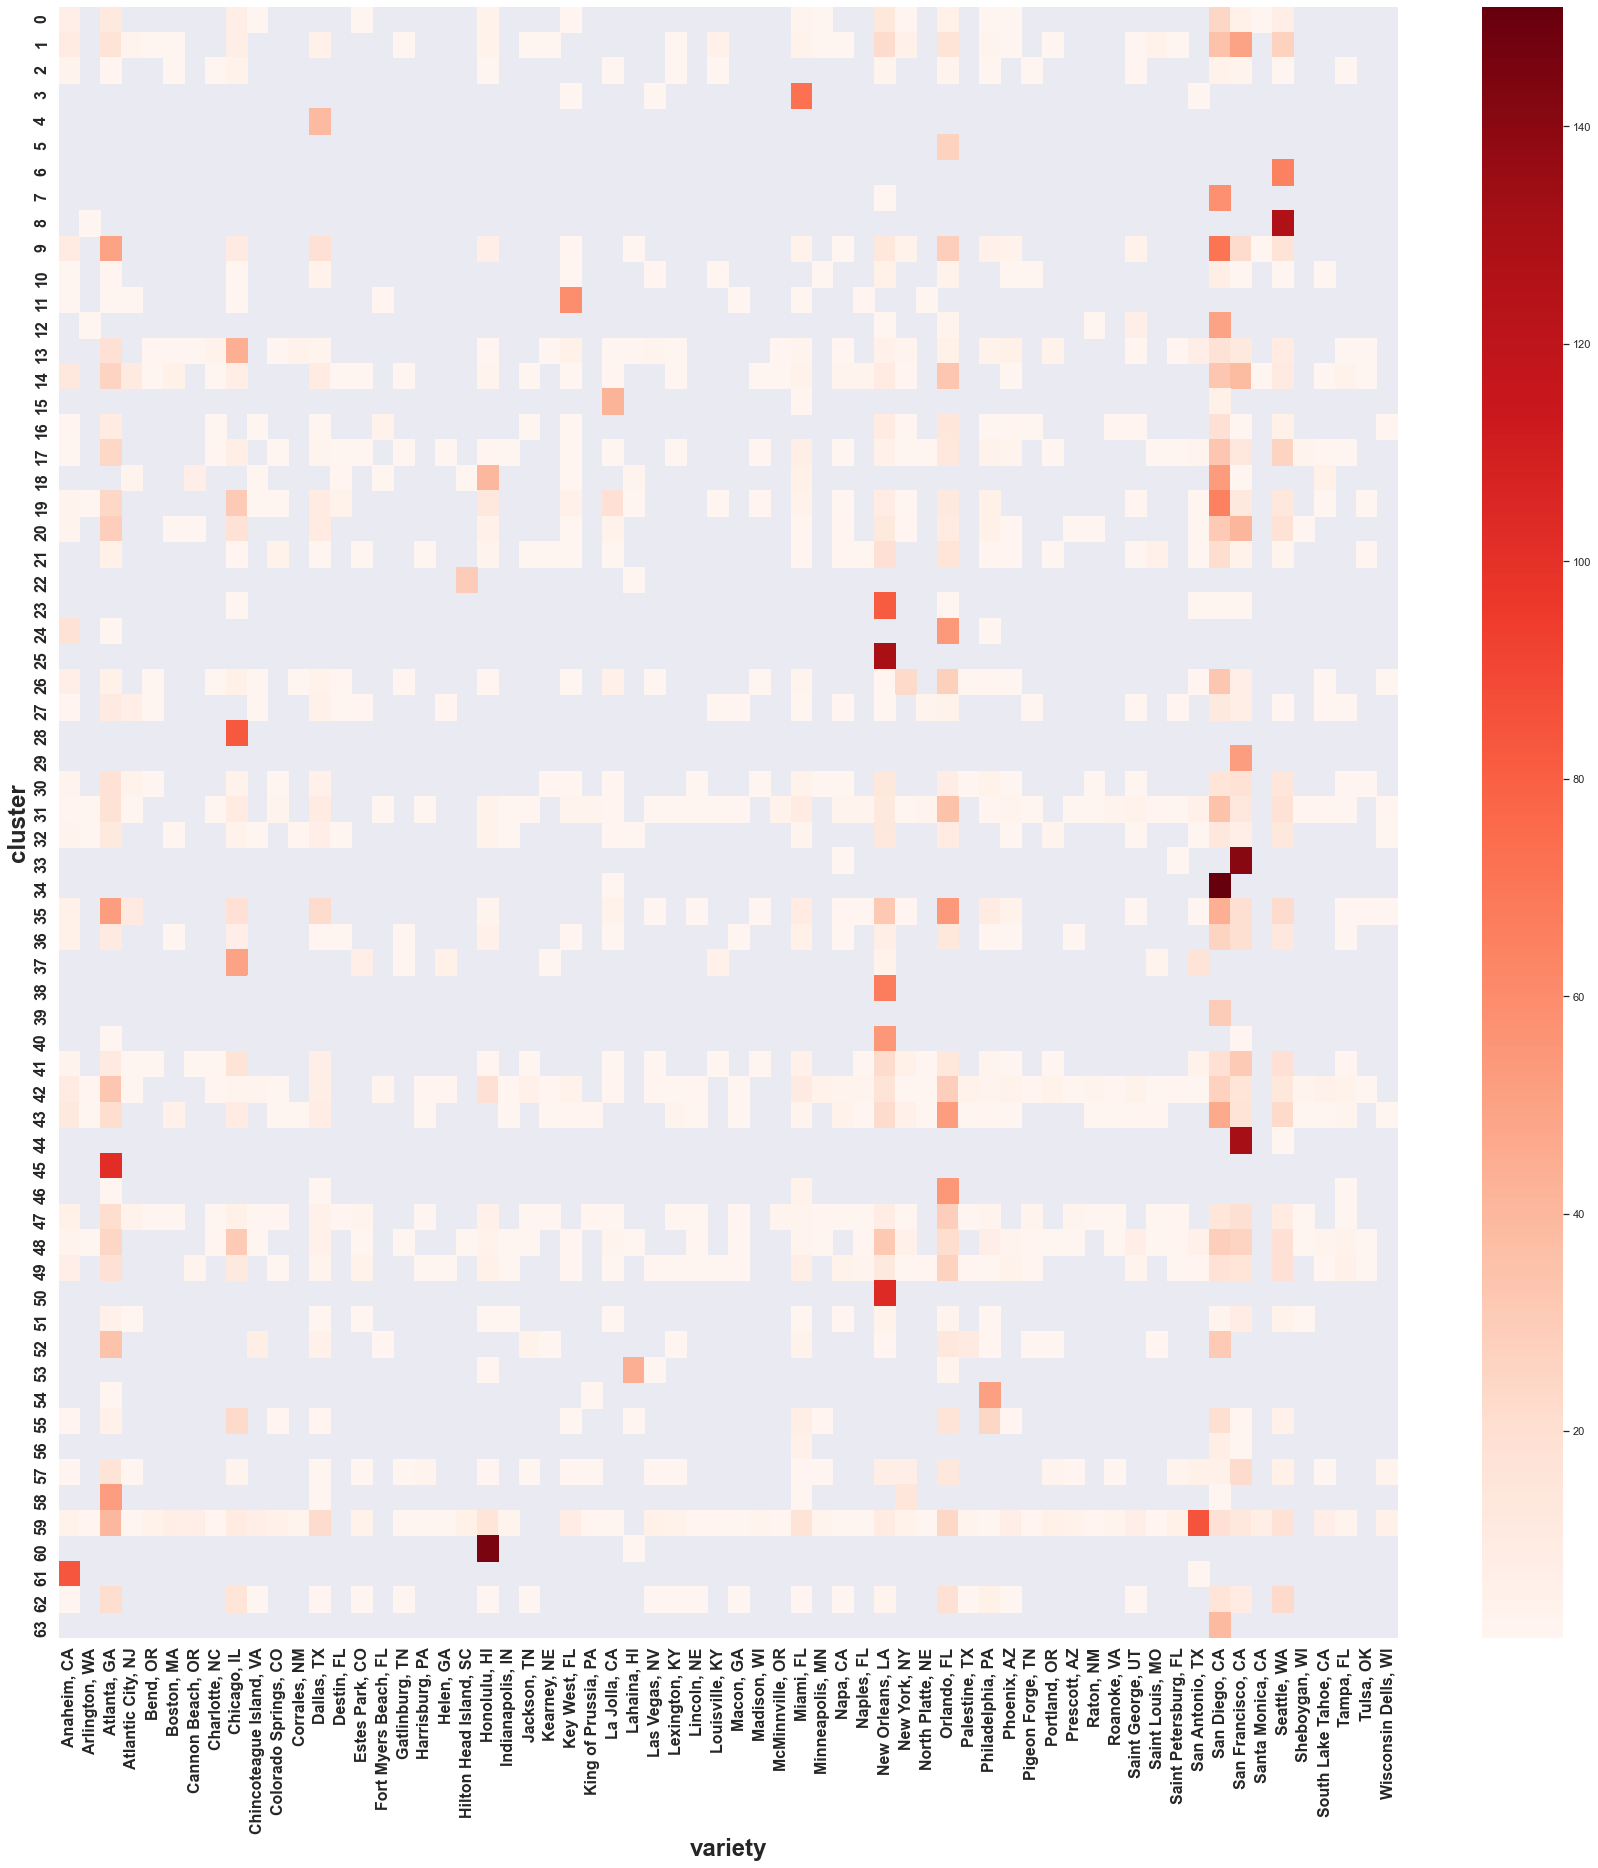

In [50]:
clusters = cutoff.groupby(['cluster', 'city_and_state']).size()
fig2, ax2 = plt.subplots(figsize = (30, 30))
sns.heatmap(clusters.unstack(level = 'city_and_state'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('City', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")
plt.savefig("001.png")